### Import Packages


In [1]:
import os
import csv
import numpy as np
from tqdm.notebook import tqdm


import matplotlib.pyplot as plt
# Module for Google Drivefrom google.colab import drive

# Module for Importing Images
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(torch.__version__)

1.9.0+cu111


In [29]:
!pip3 list


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Package               Version
--------------------- -------------------
asn1crypto            0.24.0
attrs                 17.4.0
Automat               0.6.0
bleach                2.1.2
blinker               1.4
boto                  2.44.0
certifi               2018.1.18
chardet               3.0.4
click                 6.7
cloud-init            18.2
colorama              0.3.7
command-not-found     0.3
configobj             5.0.6
constantly            15.1.0
cryptography          2.1.4
cycler                0.11.0
dataclasses           0.8
decorator             4.1.2
distro-info           0.18ubuntu0.18.04.1
entrypoints           0.2.3.post1
google-compute-engine 2.7.5
html5lib              0.999999999
httplib2              0.9.2
hyperlink             17.3.1
idna                  2.6
incremental       

In [2]:
torch.cuda.is_available()

True

### Import your drive's contents!

In [ ]:
#drive.mount('/content/drive')

Mounted at /content/drive


### Let's define some path, and our PokeMon dataset
- Put the "pokemon" folder to somewhere of your Google Drive, and define the train/test path to "train_path" and "test_path"
- To 'model_dir', put the drive's directory path that you want to save your model

In [6]:
train_path = '/home/weixing/pokemon/data/train' 
val_path = '/home/weixing/pokemon/data/test'
model_dir = '/home/weixing/pokemon/models'    #./drive/MyDrive/Path/To/Save/Your/Model
classes = ['bug', 'electric', 'fighting', 'fire', 'flying', 'grass', 'ground', 'phychic', 'poison', 'water']

In [4]:
class PokemonDataset(Dataset):
    def __init__(self, data_path, classes):
        self.data_path = data_path
        self.classes = classes

        # organize path information for __len__ and __getitem__
        self.img_path_label = list()
        for c in self.classes:
            img_list = os.listdir(os.path.join(self.data_path, c))
            for fp in img_list:
                full_fp = os.path.join(self.data_path, c, fp)
                self.img_path_label.append((full_fp, c, self.classes.index(c)))

        # Add some tranforms for data augmentation.
        self.tensor_transform = torchvision.transforms.ToTensor()
        self.preprocess = torchvision.transforms.Compose([
                torchvision.transforms.Resize(224),
                torchvision.transforms.CenterCrop(224),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])

    def __len__(self):
        return len(self.img_path_label)

    def __getitem__(self, idx):
        (fp, class_name, class_label) = self.img_path_label[idx]
        img = Image.open(fp)
        original_img = self.tensor_transform(img)
        input = self.preprocess(img)

        sample = dict()
        sample['input'] = input
        sample['original_img'] = original_img
        sample['target'] = class_label
        sample['class_name'] = class_name

        return sample

### Set DataSet and DataLoader

In [7]:
batch_size = 16

train_dataset = PokemonDataset(train_path, classes)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = PokemonDataset(val_path, classes)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(classes)

### Take a sample and try to look at the one

In [5]:
sample = next(iter(train_dataloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


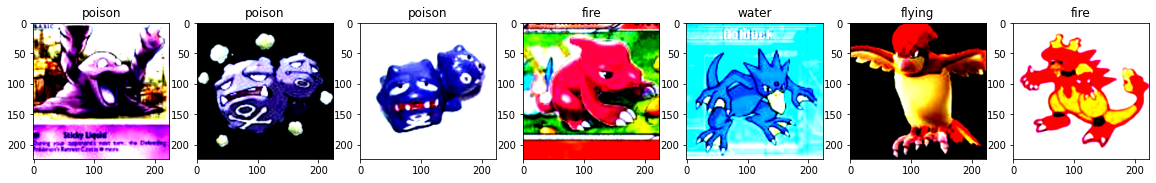

In [6]:
fig, ax = plt.subplots(1, 7, figsize=(20, 10))
for i in range(7):
    ax[i].imshow(sample['input'][i].permute(1, 2, 0))
    ax[i].set_title(sample['class_name'][i])

### Choose your device - use GPU or not?

In [8]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
print('Current Device : {}'.format(device))

Current Device : cuda


### Define the model with the pre-trained ResNet

In [ ]:
def load_checkpoint(model,filepath):
    if os.path.isfile(filepath):
        print("=> loading checkpoint '{}'".format(filepath))
        checkpoint = torch.load(filepath)
        model.load_state_dict(checkpoint['state_dict'])

    return model

In [9]:
class Model(nn.Module):
    def __init__(self, feat_dim = 2048, output_dim =num_classes,cppath = None):
        super(Model, self).__init__()
        self.cppath = cppath
        self.feat_dim = feat_dim
        self.output_dim = output_dim

        self.backbone = torchvision.models.__dict__["resnet50"](pretrained=True)
        # add dataparallel to resolve state_dict key conflict
        self.backbone = nn.DataParallel(self.backbone, device_ids=[0])
        if self.cppath:
            print("=> loading checkpoint '{}'".format(cppath))
            checkpoint = torch.load(cppath)
            self.backbone.load_state_dict(checkpoint['state_dict'])
        

        self.backbone.fc = nn.Linear(feat_dim, output_dim)
        
    def _load_checkpoint(self,model):
        if os.path.isfile(filepath):
            print("=> loading checkpoint '{}'".format(filepath))
            checkpoint = torch.load(filepath)
            model.load_state_dict(checkpoint['state_dict'])

        return model

    def forward(self, img):
        out = self.backbone(img) 
        return out

### Create a model and its optimizer


In [9]:

sample['input'].shape

torch.Size([16, 3, 224, 224])

In [20]:
checkpoint = torch.load("/home/weixing/pokemon/models/deepaugment_and_augmix.pth.tar")
checkpoint['state_dict'].keys()

odict_keys(['module.conv1.weight', 'module.bn1.weight', 'module.bn1.bias', 'module.bn1.running_mean', 'module.bn1.running_var', 'module.bn1.num_batches_tracked', 'module.layer1.0.conv1.weight', 'module.layer1.0.bn1.weight', 'module.layer1.0.bn1.bias', 'module.layer1.0.bn1.running_mean', 'module.layer1.0.bn1.running_var', 'module.layer1.0.bn1.num_batches_tracked', 'module.layer1.0.conv2.weight', 'module.layer1.0.bn2.weight', 'module.layer1.0.bn2.bias', 'module.layer1.0.bn2.running_mean', 'module.layer1.0.bn2.running_var', 'module.layer1.0.bn2.num_batches_tracked', 'module.layer1.0.conv3.weight', 'module.layer1.0.bn3.weight', 'module.layer1.0.bn3.bias', 'module.layer1.0.bn3.running_mean', 'module.layer1.0.bn3.running_var', 'module.layer1.0.bn3.num_batches_tracked', 'module.layer1.0.downsample.0.weight', 'module.layer1.0.downsample.1.weight', 'module.layer1.0.downsample.1.bias', 'module.layer1.0.downsample.1.running_mean', 'module.layer1.0.downsample.1.running_var', 'module.layer1.0.downs

In [30]:
model = Model(cppath="/home/weixing/pokemon/models/deepaugment_and_augmix.pth.tar")
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=1e-3,momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

=> loading checkpoint '/home/weixing/pokemon/models/deepaugment_and_augmix.pth.tar'


In [22]:
model(sample['input'].to(device)).shape

/home/weixing/.local/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([16, 1000])

### Define functions for train/test



In [31]:
def train(model, optimizer, sample):
    model.train()

    criterion = nn.CrossEntropyLoss()

    optimizer.zero_grad()

    input = sample['input'].float().to(device)
    target = sample['target'].long().to(device) 
    
    pred = model(input)
    pred_loss = criterion(pred, target)
    
    top_val, top_idx = torch.topk(pred, 1)

    num_correct = torch.sum(top_idx == target.view(-1, 1))
    
    pred_loss.backward()
       
    optimizer.step()

    return pred_loss.item(), num_correct.item()

In [32]:
def val(model, sample):
    model.eval()

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        input = sample['input'].float().to(device)
        target = sample['target'].long().to(device) 

        pred = model(input)
        pred_loss = criterion(pred, target)

        top_val, top_idx = torch.topk(pred, 1)

        num_correct = torch.sum(top_idx == target.view(-1, 1))

    return pred_loss.item(), num_correct.item()

### Run Training

In [35]:
max_epoch = 20
save_stride = 5
tmp_path = './checkpoint.pth'
max_accu = -1
#create checkpoint folder
from datetime import datetime
today = datetime.now()
checkpoint_path =os.path.join(model_dir,today.strftime('%Y%m%d'))
from pathlib import Path
Path(checkpoint_path).mkdir(parents=True, exist_ok=True)

p_train_loss = []
p_train_acc = []
p_val_loss = []
p_val_loss = []



for epoch in range(max_epoch):        
    ###Train Phase
    print('Epoch {}/{}'.format(epoch, max_epoch - 1))
    print('current learning rate:'.format(exp_lr_scheduler.get_lr()))
    print('-' * 10)
    
    # Initialize Loss and Accuracy
    train_loss = 0.0
    train_accu = 0.0
    

    # Load the saved MODEL AND OPTIMIZER after evaluation.
    if epoch > 0:
        checkpoint = torch.load(tmp_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        # how about learning rate scheduler?

    # Iterate over the train_dataloader
    with tqdm(total=len(train_dataloader)) as pbar:
        for idx, sample in enumerate(train_dataloader):
            curr_loss, num_correct = train(model, optimizer, sample)
            train_loss += curr_loss / len(train_dataloader)
            train_accu += num_correct / len(train_dataset)
            pbar.update(1)
    #schedule training lr
    exp_lr_scheduler.step()

    # save the model and optimizer's information before the evaulation
    checkpoint = {
        'model' : Model(),
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    
    # Save the checkpoint - you can try to save the "best" model with the validation accuracy/loss
    torch.save(checkpoint, tmp_path)
    if (epoch+1) % save_stride == 0:
        torch.save(checkpoint, os.path.join(checkpoint_path, 'pokemon_r50_{}.pth'.format(epoch+1)))
    torch.save(checkpoint, os.path.join(checkpoint_path, 'pokemon_r50_recent.pth'))
    
    ### Test Phase
    # Initialize Loss and Accuracy
    test_loss = 0.0
    test_accu = 0.0

    # Iterate over the test_dataloader
    for idx, sample in enumerate(val_dataloader):
        curr_loss, num_correct = val(model, sample)
        test_loss += curr_loss / len(test_dataloader)
        test_accu += num_correct / len(test_dataset)


    max_accu = max(test_accu, max_accu)
    if max_accu == test_accu:
        # Save your best model to the checkpoint
        torch.save(checkpoint, os.path.join(checkpoint_path, 'pokemon_r50_best.pth'))

    print("train_acc:{}, val_acc{}".format(train_accu, test_accu))
    

Epoch 0/19
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



train acc:0.7378022910479437,val acc0.7666666666666667
Epoch 1/19
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



train acc:0.9728468392023794,val acc0.8166666666666667
Epoch 2/19
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



train acc:0.9940602460755233,val acc0.8
Epoch 3/19
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



train acc:0.9949087823504491,val acc0.8166666666666667
Epoch 4/19
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



train acc:0.9961815867628379,val acc0.8
Epoch 5/19
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



train acc:0.9983029274501523,val acc0.8166666666666667
Epoch 6/19
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



train acc:0.9987271955876151,val acc0.8
Epoch 7/19
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



train acc:0.9995757318625409,val acc0.8
Epoch 8/19
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



train acc:0.9961815867628379,val acc0.8166666666666667
Epoch 9/19
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



train acc:0.9970301230377636,val acc0.8
Epoch 10/19
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



train acc:0.9974543911752265,val acc0.8166666666666667
Epoch 11/19
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



train acc:0.9966058549003007,val acc0.8
Epoch 12/19
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



train acc:0.9966058549003007,val acc0.8
Epoch 13/19
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



train acc:0.995757318625375,val acc0.8
Epoch 14/19
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



train acc:0.9974543911752265,val acc0.8
Epoch 15/19
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



train acc:0.9974543911752265,val acc0.8333333333333334
Epoch 16/19
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



train acc:0.9987271955876151,val acc0.8166666666666667
Epoch 17/19
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



train acc:0.9970301230377636,val acc0.8
Epoch 18/19
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



train acc:0.9978786593126894,val acc0.8
Epoch 19/19
----------


Widget Javascript not detected.  It may not be installed or enabled properly.



train acc:0.9974543911752265,val acc0.8


# Test

In [11]:
checkpoint_path = '/home/weixing/pokemon/models/20211209'
test_model_path = os.path.join(checkpoint_path,'pokemon_r50_best.pth')
test_path = '/home/weixing/pokemon/data/test'


In [12]:
test_dataset = PokemonDataset(test_path, classes)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [14]:
checkpoint = torch.load(test_model_path)
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

In [15]:
def test(model, sample):
    model.eval()

    with torch.no_grad():
        input = sample['input'].float().to(device)
        target = sample['target'].long().to(device) 

        pred = model(input)

        top_val, top_idx = torch.topk(pred, 1)

        num_correct = torch.sum(top_idx == target.view(-1, 1))

    return num_correct.item()

In [16]:
test_accu = 0.0

# Iterate over the val_dataloader
with tqdm(total=len(test_dataloader)) as pbar:
    for idx, sample in enumerate(test_dataloader):
        num_correct = test(model, sample)
        test_accu += num_correct / len(test_dataloader)
        pbar.update(1)

print('Total Accuracy: ', test_accu)

Widget Javascript not detected.  It may not be installed or enabled properly.


/home/weixing/.local/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Total Accuracy:  0.8333333333333343
